In [1]:
import pandas as pd
import numpy as np
import time
import os, psutil
import pickle
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
def printmem():
    process = psutil.Process(os.getpid())
    print("   memory:",round(process.memory_info().rss/(10**9),3),'Gbytes')  # in bytes 
    
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tabulate import tabulate

from keras import models
from keras import layers
from tensorflow import keras

def calc_performance_CNN(y_vals_true, y_vals_pred,labels,label_names={},max_letters_label=-1):
#
# Get the numbers for the confusion matrix
# To get output: cf_matrix[true_label,pred_label]
    cf_matrix = confusion_matrix(y_vals_true, y_vals_pred, labels=labels)
#
# This is a graphic
    cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=labels)
#
# Make the header row
    header = [""]
    for column_name in labels:
        header.append('Pred:' + str(column_name))
    table = [header]
#
# Now make the rows with the matrix
    for row_name in labels:
        row_label = row_name
        if row_name in label_names:
            row_label = label_names[row_name]
            if max_letters_label > 0:
                row_label = row_label[:max_letters_label]
        row = ['True:'+str(row_label)]
        for column_name in labels:
            row_index = labels.index(row_name)
            column_index = labels.index(column_name)
            row.append(cf_matrix[row_index,column_index])
        table.append(row)
    # table = [
    #     [ "", "Predicted Class 1", "Precicted Class 0"],
    #     [ "True Class 1", TP, FN ],
    #     [ "True Class 0", FP, TN ]
    # ]
    print_table_type='fancy_grid'
    print_table = tabulate(table, headers='firstrow', tablefmt=print_table_type)
#    print(print_table)
#
# Get the recall, precision, ands F1 for each individual label
# - return both the "string report" (which you can print)
# - and the "dictionary report" (which you can use for averages and so on)
    report = classification_report(y_vals_true,y_vals_pred)
    report_dict = classification_report(y_vals_true,y_vals_pred,output_dict=True)
#
    results = {"confusionMatrix":cf_matrix,
                    'confusion_matrix_display':cf_disp,
                    'confusion_matrix_print_table':print_table,      
                    "report":report,"report_dict":report_dict}
    return results




2024-12-11 01:05:31.395520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 01:05:31.543769: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 01:05:31.549706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-11 01:05:31.549722: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [7]:
dfTrain = pd.read_csv('train_Normal.zip')

In [8]:
df = dfTrain.head(10000)

X = df.iloc[:, 0:-2].to_numpy()
y = df['severity'].values
#y = df['pathoClass'].values
labels = [0,1,2,3,4]
severity_map = {0:'Most',
          1:'More',
          2:'Intermediate',
          3:'Less',
          4:'Least'}
#labels = list(range(0,49))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [3]:
num_classes = len(labels)

In [27]:
t0 = time.time()

model_cnn = models.Sequential()
# 
model_cnn.add(layers.Conv1D(100, 10, activation='relu', input_shape=(462,1)))
#
# Anoth convolutional layer
model_cnn.add(layers.Conv1D(100, 10, activation='relu'))
#
# Max pooling 
model_cnn.add(layers.MaxPooling1D(3))
#
# Two more convolutional layers
model_cnn.add(layers.Conv1D(80, 10, activation='relu'))
#model_cnn.add(layers.Conv1D(80, 10, activation='relu'))
#
# Global average pooling use this instead of "Flatten" - it helps reduce overfitting
model_cnn.add(layers.GlobalAveragePooling1D())
#model_m.add(Flatten())

model_cnn.add(layers.Dropout(0.5))    # 

model_cnn.add(layers.Dense(num_classes, activation='softmax'))
print(model_cnn.summary())

patience = 5
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_cnnVary.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
]

model_cnn.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 100
EPOCHS = 20

#
# Now fit
history = model_cnn.fit(X_train,y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_data=(X_test, y_test),
                      verbose=1)
print("Done! CNN time:", time.time()-t0)
best_val_acc =  max(history.history['val_accuracy'])
print("Best validation accuracy is:",best_val_acc)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 453, 100)          1100      
                                                                 
 conv1d_44 (Conv1D)          (None, 444, 100)          100100    
                                                                 
 global_average_pooling1d_14  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 5)                 505       
                                                                 
Total params: 101,705
Trainable params: 101,705
Non-trainable params: 0
_______________________________________________

In [28]:
#dfh = pd.DataFrame()
#dfh['accuracy'] = history.history['accuracy']
#dfh['loss'] = history.history['loss']
dfh['val_accuracy_3'] = history.history['val_accuracy']
#dfh['val_loss_1'] = history.history['val_loss']
#iterations = len(dfh)
#dfh['iteration'] = range(0,iterations)
#print("Number of iterations:",iterations)

display(dfh.style)
#import plotly.express as px
#import plotly.io as pio
#pio.renderers.default='plotly_mimetype'
#
# ACCURACY
#fig = px.line(dfh, x='iteration', y=['accuracy','val_accuracy'], title='Accuracy vs Iteration')
#fig.show("plotly_mimetype")
#
# Loss
#fig = px.line(dfh, x='iteration', y=['loss','val_loss'], title='Loss vs Iteration')
#fig.show("plotly_mimetype")



,val_accuracy_1,val_accuracy_2,val_accuracy_3
0,0.315000,0.315000,0.315000
1,0.321000,0.326000,0.320500
2,0.474000,0.381500,0.369000
3,0.563000,0.496000,0.354000
4,0.707500,0.559500,0.384000
5,0.788000,0.616500,0.330500
6,0.896500,0.637000,0.424000
7,0.907000,0.682500,0.451000
8,0.944500,0.762500,0.481000
9,0.946000,0.807000,0.486500


In [29]:
dfh.to_csv('AccDecrease.csv',index=False)

In [23]:
1

1

Keras FAQ "Why is my training loss much higher than my testing loss?"

https://keras.io/getting_started/faq/

313/313 [==============================] - 3s 9ms/step
╒═══════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│                   │   Pred:0 │   Pred:1 │   Pred:2 │   Pred:3 │   Pred:4 │
╞═══════════════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ True:Most         │     3226 │        3 │       26 │        0 │        0 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:More         │        1 │     7996 │        1 │        0 │        0 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:Intermediate │        0 │        6 │    11906 │        1 │        0 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:Less         │        0 │        7 │       11 │    12483 │      173 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:Least        │        0 │        0 │        1 │        2 │     4157 │
╘═══════════════════╧

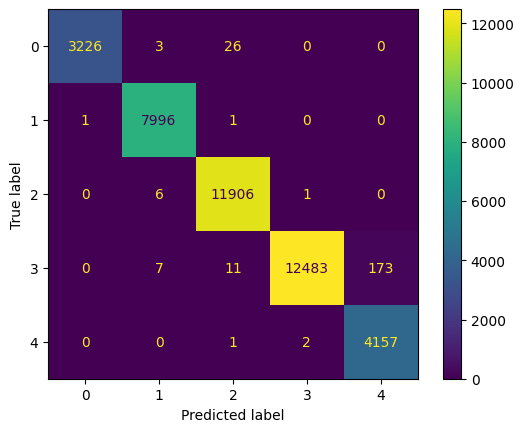

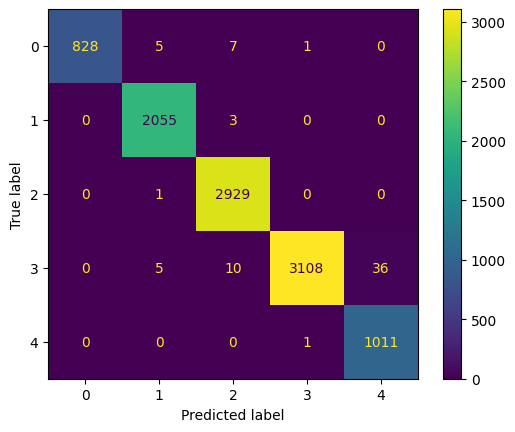

In [9]:
# Get the individual model_m for each sample in the test set
predictions = model_cnn.predict(X_train)
#
# Remove code below for student version!
#
# Get the max probabilites for each rows
train_probs = np.max(predictions, axis = 1)
#
# Get the predicted classes for each row
train_preds = np.argmax(predictions, axis = 1)


# Get the individual model_m for each sample in the test set
predictions = model_cnn.predict(X_test)
#
# Remove code below for student version!
#
# Get the max probabilites for each rows
test_probs = np.max(predictions, axis = 1)
#
# Get the predicted classes for each row
test_preds = np.argmax(predictions, axis = 1)

#==================================================================

#For severity classification

results_train = calc_performance_CNN(y_train, train_preds, labels, severity_map, max_letters_label=12)
results_train['confusion_matrix_display'].plot()
#plt.savefig('TrainMatrixCNN.png')

results_test = calc_performance_CNN(y_test, test_preds, labels, severity_map, max_letters_label=12)
results_test['confusion_matrix_display'].plot()
#plt.savefig('TestMatrixCNN.png')

print(results_train['confusion_matrix_print_table'])
print(results_test['confusion_matrix_print_table'])

#==================================================================

#For pathology classification

#For pathology classification

#pathologies = dfTrain.PATHOLOGY.unique()
#revPathDict = {0: 'URTI',1: 'HIV (initial infection)',2: 'Pneumonia',3: 'Chronic rhinosinusitis',4: 'Viral pharyngitis',
 #              5: 'Anemia',6: 'Atrial fibrillation',7: 'Allergic sinusitis',8: 'Larygospasm',
  #             9: 'Cluster headache',10: 'Anaphylaxis',11: 'Spontaneous pneumothorax',12: 'Acute pulmonary edema',
   #            13: 'Tuberculosis',14: 'Myasthenia gravis',15: 'Panic attack',16: 'Scombroid food poisoning',
    #           17: 'Epiglottitis',18: 'Inguinal hernia',19: 'Boerhaave',20: 'Pancreatic neoplasm',21: 'Bronchitis',
     #          22: 'SLE',23: 'Acute laryngitis',24: 'Unstable angina',25: 'Bronchiectasis',26: 'Possible NSTEMI / STEMI',
      #         27: 'Chagas',28: 'Localized edema',29: 'Sarcoidosis',30: 'Spontaneous rib fracture',31: 'GERD',
       #        32: 'Bronchospasm / acute asthma exacerbation',33: 'Acute COPD exacerbation / infection',
        #       34: 'Guillain-Barré syndrome',35: 'Influenza',36: 'Pulmonary embolism',37: 'Stable angina',
         #      38: 'Pericarditis',39: 'Acute rhinosinusitis',40: 'Whooping cough',41: 'Myocarditis',
          #     42: 'Acute dystonic reactions',43: 'Pulmonary neoplasm',44: 'Acute otitis media',
           #    45: 'PSVT',46: 'Croup',47: 'Ebola',48: 'Bronchiolitis'}


#confTrain = pd.DataFrame(results_train['confusionMatrix'])
#confTest = pd.DataFrame(results_test['confusionMatrix'])

#confTrain.to_csv('confMatTrain1.csv', index=False)
#confTest.to_csv('confMatTest1.csv', index=False)
#==================================================================



In [16]:
printmem()

   memory: 8.546 Gbytes


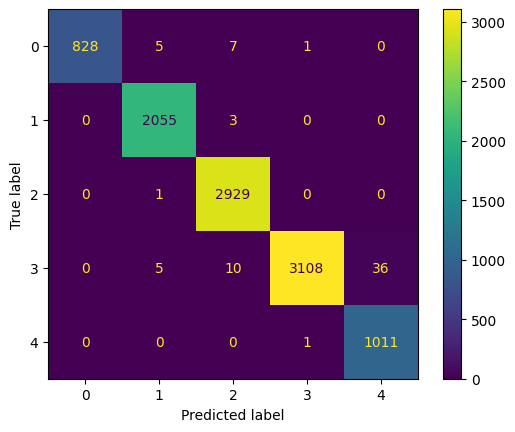

In [17]:
results_test['confusion_matrix_display'].plot()
plt.savefig('output/Test.png')